In [1]:
# UK Energy Grid Analysis
# Exploring electricity generation patterns, renewable energy trends, and grid dynamics

import sys
sys.path.insert(0, '../')

# Import our production code
from src.data.fetch_data import ElexonDataFetcher

# Data libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Settings
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")

Libraries loaded
Analysis date: 2026-01-20


In [2]:
# Fetch 30 days of historical data for comprehensive analysis
print("Fetching 30 days of UK electricity generation data...")

fetcher = ElexonDataFetcher()
df = fetcher.fetch_historical_data(days=30)

print(f"\n📊 Dataset Overview:")
print(f"  Records: {len(df):,}")
print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"  Fuel types: {df['fuel_type'].nunique()}")
print(f"  Time periods: {df['timestamp'].nunique()}")

# Quick peek at the data
print(f"\n🔍 Sample data:")
display(df.head())

# Save for later use
df.to_csv('../data/processed/uk_generation_30days.csv', index=False)
print("\nData fetched and saved")

INFO:src.data.fetch_data:Fetching chunk: 2025-12-21 to 2025-12-28
INFO:src.data.fetch_data:Fetching generation data from 2025-12-21 22:25:10.382531 to 2025-12-28 22:25:10.382531
INFO:src.data.fetch_data:API request completed in 95.86ms - Status: 200
INFO:src.data.fetch_data:Successfully fetched 3696 records


Fetching 30 days of UK electricity generation data...


INFO:src.data.fetch_data:Fetching chunk: 2025-12-28 to 2026-01-04
INFO:src.data.fetch_data:Fetching generation data from 2025-12-28 22:25:10.382531 to 2026-01-04 22:25:10.382531
INFO:src.data.fetch_data:API request completed in 51.01ms - Status: 200
INFO:src.data.fetch_data:Successfully fetched 3696 records
INFO:src.data.fetch_data:Fetching chunk: 2026-01-04 to 2026-01-11
INFO:src.data.fetch_data:Fetching generation data from 2026-01-04 22:25:10.382531 to 2026-01-11 22:25:10.382531
INFO:src.data.fetch_data:API request completed in 70.17ms - Status: 200
INFO:src.data.fetch_data:Successfully fetched 3696 records
INFO:src.data.fetch_data:Fetching chunk: 2026-01-11 to 2026-01-18
INFO:src.data.fetch_data:Fetching generation data from 2026-01-11 22:25:10.382531 to 2026-01-18 22:25:10.382531
INFO:src.data.fetch_data:API request completed in 55.56ms - Status: 200
INFO:src.data.fetch_data:Successfully fetched 2673 records
INFO:src.data.fetch_data:Fetching chunk: 2026-01-18 to 2026-01-20
INFO:sr


📊 Dataset Overview:
  Records: 11,869
  Date range: 2025-12-22 07:00:00+00:00 to 2026-01-20 20:30:00+00:00
  Fuel types: 11
  Time periods: 1079

🔍 Sample data:


,timestamp,fuel_type,generation_mw,total_generation
0,2025-12-22 07:00:00+00:00,Wind Offshore,8359.977,27487.454
1,2025-12-22 07:00:00+00:00,Solar,0.000,27487.454
2,2025-12-22 07:00:00+00:00,Other,651.000,27487.454
3,2025-12-22 07:00:00+00:00,Nuclear,3480.000,27487.454
4,2025-12-22 07:00:00+00:00,Hydro Run-of-river and poundage,606.000,27487.454



Data fetched and saved


In [3]:
# Prepare data for visualization
df_pivot = df.pivot_table(
    index='timestamp',
    columns='fuel_type', 
    values='generation_mw',
    aggfunc='sum'
).fillna(0)

# Calculate totals and renewable percentage
renewables = ['Solar', 'Wind Offshore', 'Wind Onshore', 
              'Hydro Run-of-river and poundage', 'Hydro Pumped Storage', 'Biomass']

df_pivot['Total'] = df_pivot.sum(axis=1)
df_pivot['Renewables'] = df_pivot[renewables].sum(axis=1)
df_pivot['Renewable_Pct'] = (df_pivot['Renewables'] / df_pivot['Total']) * 100

# Add time features for analysis
df_pivot['Date'] = df_pivot.index.date
df_pivot['Hour'] = df_pivot.index.hour
df_pivot['Day_of_Week'] = df_pivot.index.day_name()

print(f"📈 Summary Statistics (30 days):")
print(f"  Average total generation: {df_pivot['Total'].mean():,.0f} MW")
print(f"  Average renewable %: {df_pivot['Renewable_Pct'].mean():.1f}%")
print(f"  Peak renewable %: {df_pivot['Renewable_Pct'].max():.1f}%")
print(f"  Lowest renewable %: {df_pivot['Renewable_Pct'].min():.1f}%")

print(f"\n⚡ Generation by source (average MW):")
for fuel in df_pivot.columns[:11]:  # First 11 are fuel types
    print(f"  {fuel:30s}: {df_pivot[fuel].mean():8,.0f} MW")

📈 Summary Statistics (30 days):
  Average total generation: 34,738 MW
  Average renewable %: 49.5%
  Peak renewable %: 77.1%
  Lowest renewable %: 18.4%

⚡ Generation by source (average MW):
  Biomass                       :    2,559 MW
  Fossil Gas                    :   13,309 MW
  Fossil Hard coal              :        0 MW
  Fossil Oil                    :        0 MW
  Hydro Pumped Storage          :      229 MW
  Hydro Run-of-river and poundage:      531 MW
  Nuclear                       :    3,904 MW
  Other                         :      682 MW
  Solar                         :      750 MW
  Wind Offshore                 :    8,373 MW
  Wind Onshore                  :    4,400 MW


In [4]:
# Visualization 1: 30-Day Generation Mix (Stacked Area Chart)

# Define professional color scheme
colors = {
    'Nuclear': '#E74C3C',           # Red
    'Fossil Gas': '#95A5A6',        # Gray
    'Fossil Hard coal': '#34495E',  # Dark gray
    'Wind Offshore': '#3498DB',     # Blue
    'Wind Onshore': '#5DADE2',      # Light blue
    'Solar': '#F39C12',             # Orange
    'Biomass': '#27AE60',           # Green
    'Hydro Run-of-river and poundage': '#16A085', # Teal
    'Hydro Pumped Storage': '#1ABC9C', # Light teal
    'Other': '#7F8C8D',             # Light gray
    'Fossil Oil': '#2C3E50'         # Very dark gray
}

# Order for stacking (fossil at bottom, renewables on top)
fuel_order = [
    'Fossil Hard coal', 'Fossil Oil', 'Fossil Gas', 'Nuclear', 'Other',
    'Biomass', 'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
    'Solar', 'Wind Onshore', 'Wind Offshore'
]

fig = go.Figure()

# Add traces in order
for fuel_type in fuel_order:
    if fuel_type in df_pivot.columns:
        fig.add_trace(go.Scatter(
            x=df_pivot.index,
            y=df_pivot[fuel_type],
            name=fuel_type,
            mode='lines',
            stackgroup='one',
            fillcolor=colors.get(fuel_type, '#95A5A6'),
            line=dict(width=0.5, color=colors.get(fuel_type, '#95A5A6')),
            hovertemplate='<b>%{fullData.name}</b><br>%{y:,.0f} MW<extra></extra>'
        ))

fig.update_layout(
    title={
        'text': 'UK Electricity Generation Mix - Last 30 Days',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'family': 'Arial, sans-serif'}
    },
    xaxis_title='Date',
    yaxis_title='Generation (MW)',
    hovermode='x unified',
    height=600,
    width=1400,
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.02,
        font=dict(size=11)
    ),
    margin=dict(r=150)
)

fig.show()

In [5]:
# Visualization 2: Renewable Energy Percentage Trend

fig = go.Figure()

# Add renewable percentage line
fig.add_trace(go.Scatter(
    x=df_pivot.index,
    y=df_pivot['Renewable_Pct'],
    mode='lines',
    name='Renewable %',
    line=dict(color='#27AE60', width=2.5),
    fill='tozeroy',
    fillcolor='rgba(39, 174, 96, 0.2)',
    hovertemplate='<b>Renewable Energy</b><br>%{y:.1f}%<extra></extra>'
))

# Add mean line
mean_renewable = df_pivot['Renewable_Pct'].mean()
fig.add_hline(
    y=mean_renewable,
    line_dash="dash",
    line_color="red",
    annotation_text=f"30-day average: {mean_renewable:.1f}%",
    annotation_position="top right"
)

# Add 50% target line
fig.add_hline(
    y=50,
    line_dash="dot",
    line_color="gray",
    annotation_text="50% threshold",
    annotation_position="bottom right"
)

fig.update_layout(
    title={
        'text': 'UK Renewable Energy Percentage - 30 Day Trend',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'family': 'Arial, sans-serif'}
    },
    xaxis_title='Date',
    yaxis_title='Renewable Energy (%)',
    height=600,
    width=1400,
    template='plotly_white',
    hovermode='x unified',
    yaxis=dict(range=[0, 100]),
    margin=dict(l=80, r=80, t=100, b=80)
)

fig.show()

print(f"\n📊 Renewable Energy Insights:")
print(f"  • UK exceeded 50% renewable for {(df_pivot['Renewable_Pct'] > 50).sum()} periods ({(df_pivot['Renewable_Pct'] > 50).sum() / len(df_pivot) * 100:.1f}% of the time)")
print(f"  • Highest renewable day: {df_pivot.groupby('Date')['Renewable_Pct'].mean().idxmax()} ({df_pivot.groupby('Date')['Renewable_Pct'].mean().max():.1f}%)")
print(f"  • Volatility (std dev): {df_pivot['Renewable_Pct'].std():.1f}%")


📊 Renewable Energy Insights:
  • UK exceeded 50% renewable for 542 periods (50.2% of the time)
  • Highest renewable day: 2026-01-01 (69.1%)
  • Volatility (std dev): 14.3%


In [6]:
# Visualization 3: Average Generation by Fuel Type (30 days)

# Calculate average generation for each fuel type
fuel_averages = df_pivot[fuel_order].mean().sort_values(ascending=False)

# Group into categories
categories = {
    'Wind (Offshore + Onshore)': fuel_averages[['Wind Offshore', 'Wind Onshore']].sum(),
    'Gas': fuel_averages['Fossil Gas'],
    'Nuclear': fuel_averages['Nuclear'],
    'Biomass': fuel_averages['Biomass'],
    'Solar': fuel_averages['Solar'],
    'Hydro (All)': fuel_averages[['Hydro Pumped Storage', 'Hydro Run-of-river and poundage']].sum(),
    'Other': fuel_averages['Other'],
    'Coal': fuel_averages['Fossil Hard coal'],
    'Oil': fuel_averages['Fossil Oil']
}

# Remove zeros
categories = {k: v for k, v in categories.items() if v > 0}

# Create donut chart
fig = go.Figure(data=[go.Pie(
    labels=list(categories.keys()),
    values=list(categories.values()),
    hole=0.4,
    marker=dict(
        colors=['#3498DB', '#95A5A6', '#E74C3C', '#27AE60', 
                '#F39C12', '#16A085', '#7F8C8D'],
        line=dict(color='white', width=2)
    ),
    textinfo='label+percent',
    textfont=dict(size=14),
    hovertemplate='<b>%{label}</b><br>%{value:,.0f} MW<br>%{percent}<extra></extra>'
)])

fig.update_layout(
    title={
        'text': 'UK Average Generation Mix - Last 30 Days',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'family': 'Arial, sans-serif'}
    },
    height=700,
    width=1000,
    template='plotly_white',
    annotations=[dict(
        text=f'{df_pivot["Total"].mean():,.0f}<br>MW<br>Average',
        x=0.5, y=0.5,
        font_size=20,
        showarrow=False
    )],
    margin=dict(l=80, r=80, t=100, b=80)
)

fig.show()

print(f"\n⚡ Generation Breakdown:")
for fuel, mw in sorted(categories.items(), key=lambda x: x[1], reverse=True):
    pct = (mw / df_pivot['Total'].mean()) * 100
    print(f"  {fuel:30s}: {mw:8,.0f} MW ({pct:5.1f}%)")


⚡ Generation Breakdown:
  Gas                           :   13,309 MW ( 38.3%)
  Wind (Offshore + Onshore)     :   12,773 MW ( 36.8%)
  Nuclear                       :    3,904 MW ( 11.2%)
  Biomass                       :    2,559 MW (  7.4%)
  Hydro (All)                   :      760 MW (  2.2%)
  Solar                         :      750 MW (  2.2%)
  Other                         :      682 MW (  2.0%)


In [7]:
# Visualization 4: Renewable Percentage by Hour and Day

# Create pivot for heatmap
heatmap_data = df_pivot.pivot_table(
    index='Hour',
    columns='Day_of_Week',
    values='Renewable_Pct',
    aggfunc='mean'
)

# Reorder days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[[day for day in day_order if day in heatmap_data.columns]]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='RdYlGn',  # Red (low) to Green (high)
    text=heatmap_data.values.round(1),
    texttemplate='%{text}%',
    textfont={"size": 10},
    colorbar=dict(title="Renewable %"),
    hovertemplate='<b>%{x}</b><br>Hour: %{y}:00<br>Renewable: %{z:.1f}%<extra></extra>'
))

fig.update_layout(
    title={
        'text': 'Renewable Energy by Time of Day and Day of Week',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24, 'family': 'Arial, sans-serif'}
    },
    xaxis_title='Day of Week',
    yaxis_title='Hour of Day',
    height=700,
    width=1200,
    template='plotly_white',
    yaxis=dict(autorange='reversed'),
    margin=dict(l=80, r=80, t=100, b=80)
)

fig.show()

print(f"\n🕐 Time Pattern Insights:")
print(f"  • Peak renewable hour: {df_pivot.groupby('Hour')['Renewable_Pct'].mean().idxmax()}:00 ({df_pivot.groupby('Hour')['Renewable_Pct'].mean().max():.1f}%)")
print(f"  • Lowest renewable hour: {df_pivot.groupby('Hour')['Renewable_Pct'].mean().idxmin()}:00 ({df_pivot.groupby('Hour')['Renewable_Pct'].mean().min():.1f}%)")
print(f"  • Most renewable day: {df_pivot.groupby('Day_of_Week')['Renewable_Pct'].mean().idxmax()} ({df_pivot.groupby('Day_of_Week')['Renewable_Pct'].mean().max():.1f}%)")




🕐 Time Pattern Insights:
  • Peak renewable hour: 2:00 (57.4%)
  • Lowest renewable hour: 16:00 (44.5%)
  • Most renewable day: Saturday (55.7%)


In [8]:
# Create comprehensive dashboard with all visualizations

from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(
    rows=3, cols=2,
    row_heights=[0.35, 0.35, 0.3],
    column_widths=[0.7, 0.3],
    specs=[
        [{"type": "scatter", "colspan": 2}, None],  # Row 1: Full width stacked area
        [{"type": "scatter"}, {"type": "pie"}],      # Row 2: Line chart + Donut
        [{"type": "heatmap", "colspan": 2}, None]    # Row 3: Full width heatmap
    ],
    subplot_titles=(
        'Generation Mix Over Time (30 Days)',
        '',
        'Renewable Energy Trend',
        'Average Fuel Mix',
        'Renewable % by Hour and Day'
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# 1. Stacked Area Chart (Row 1)
for fuel_type in fuel_order:
    if fuel_type in df_pivot.columns:
        fig.add_trace(go.Scatter(
            x=df_pivot.index,
            y=df_pivot[fuel_type],
            name=fuel_type,
            mode='lines',
            stackgroup='one',
            fillcolor=colors.get(fuel_type, '#95A5A6'),
            line=dict(width=0.5),
            legendgroup='fuel',
            showlegend=True,
            hovertemplate='%{y:,.0f} MW<extra></extra>'
        ), row=1, col=1)

# 2. Renewable Percentage Line (Row 2, Left)
fig.add_trace(go.Scatter(
    x=df_pivot.index,
    y=df_pivot['Renewable_Pct'],
    mode='lines',
    name='Renewable %',
    line=dict(color='#27AE60', width=2.5),
    fill='tozeroy',
    fillcolor='rgba(39, 174, 96, 0.2)',
    legendgroup='renewable',
    showlegend=False,
    hovertemplate='%{y:.1f}%<extra></extra>'
), row=2, col=1)

# Add mean line to renewable chart
mean_renewable = df_pivot['Renewable_Pct'].mean()
fig.add_hline(
    y=mean_renewable,
    line_dash="dash",
    line_color="red",
    row=2, col=1,
    annotation_text=f"Avg: {mean_renewable:.1f}%",
    annotation_position="top right"
)

# 3. Donut Chart (Row 2, Right)
fig.add_trace(go.Pie(
    labels=list(categories.keys()),
    values=list(categories.values()),
    hole=0.5,
    marker=dict(
        colors=['#3498DB', '#95A5A6', '#E74C3C', '#27AE60', 
                '#F39C12', '#16A085', '#7F8C8D'],
        line=dict(color='white', width=2)
    ),
    textinfo='label+percent',
    textfont=dict(size=11),
    legendgroup='pie',
    showlegend=False,
    hovertemplate='<b>%{label}</b><br>%{value:,.0f} MW<extra></extra>'
), row=2, col=2)

# 4. Heatmap (Row 3)
fig.add_trace(go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='RdYlGn',
    text=heatmap_data.values.round(1),
    texttemplate='%{text}%',
    textfont={"size": 9},
    colorbar=dict(title="Renewable %", len=0.3, y=0.15),
    legendgroup='heatmap',
    showlegend=False,
    hovertemplate='%{x}<br>Hour: %{y}:00<br>%{z:.1f}%<extra></extra>'
), row=3, col=1)

# Update layout
fig.update_layout(
    title={
        'text': f'UK Energy Grid Dashboard - 30 Day Analysis<br><sub>Data from {df["timestamp"].min().strftime("%Y-%m-%d")} to {df["timestamp"].max().strftime("%Y-%m-%d")}</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 28, 'family': 'Arial, sans-serif'}
    },
    height=1400,
    width=1600,
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.98,
        xanchor="right",
        x=1.15,
        font=dict(size=10)
    ),
    margin=dict(l=80, r=250, t=150, b=80)
)

# Update axes labels
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Generation (MW)", row=1, col=1)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Renewable %", row=2, col=1, range=[0, 100])

fig.update_xaxes(title_text="Day of Week", row=3, col=1)
fig.update_yaxes(title_text="Hour", row=3, col=1, autorange='reversed')

fig.show()

print("Comprehensive dashboard created!")
print(f"\n📊 Dashboard Summary:")
print(f"  • Total periods analyzed: {len(df_pivot):,}")
print(f"  • Average generation: {df_pivot['Total'].mean():,.0f} MW")
print(f"  • Average renewable: {df_pivot['Renewable_Pct'].mean():.1f}%")
print(f"  • Wind dominates renewables: {(fuel_averages[['Wind Offshore', 'Wind Onshore']].sum() / df_pivot['Renewables'].mean() * 100):.1f}%")

Comprehensive dashboard created!

📊 Dashboard Summary:
  • Total periods analyzed: 1,079
  • Average generation: 34,738 MW
  • Average renewable: 49.5%
  • Wind dominates renewables: 75.8%


✅ Dashboard saved to assets/uk_energy_dashboard.png


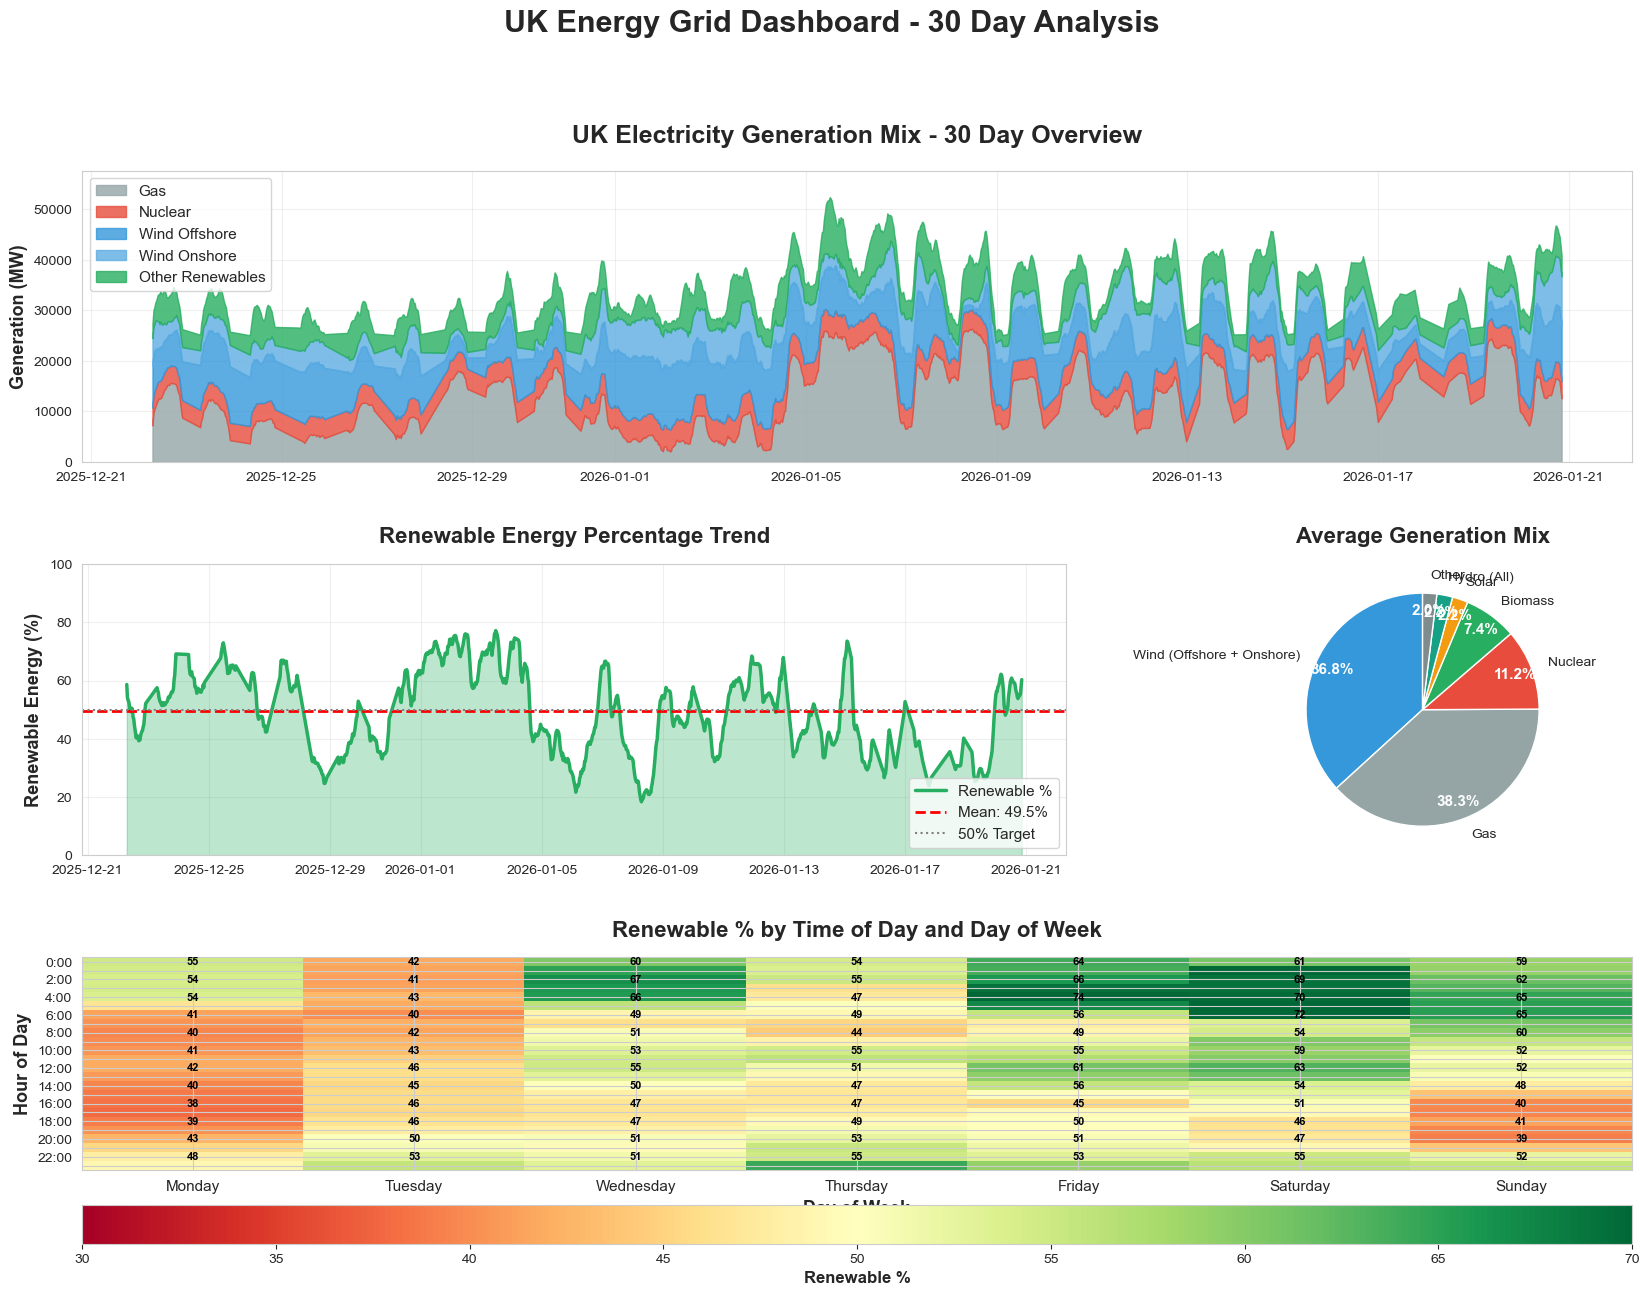

In [14]:
# Create publication-quality dashboard with Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create assets folder if it doesn't exist
os.makedirs('../assets', exist_ok=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Create figure with subplots
fig = plt.figure(figsize=(20, 14))  # Made larger
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# Color scheme
renewable_colors = ['#3498DB', '#5DADE2', '#F39C12', '#27AE60', '#16A085', '#1ABC9C']
fossil_colors = ['#95A5A6', '#34495E', '#2C3E50']

# ===== 1. STACKED AREA CHART (Top - Full Width) =====
ax1 = fig.add_subplot(gs[0, :])

# Plot stacked areas
ax1.fill_between(df_pivot.index, 0, df_pivot['Fossil Gas'], 
                  label='Gas', color='#95A5A6', alpha=0.8)
ax1.fill_between(df_pivot.index, df_pivot['Fossil Gas'], 
                  df_pivot['Fossil Gas'] + df_pivot['Nuclear'],
                  label='Nuclear', color='#E74C3C', alpha=0.8)
ax1.fill_between(df_pivot.index, 
                  df_pivot['Fossil Gas'] + df_pivot['Nuclear'],
                  df_pivot['Fossil Gas'] + df_pivot['Nuclear'] + df_pivot['Wind Offshore'],
                  label='Wind Offshore', color='#3498DB', alpha=0.8)
ax1.fill_between(df_pivot.index, 
                  df_pivot['Fossil Gas'] + df_pivot['Nuclear'] + df_pivot['Wind Offshore'],
                  df_pivot['Fossil Gas'] + df_pivot['Nuclear'] + df_pivot['Wind Offshore'] + df_pivot['Wind Onshore'],
                  label='Wind Onshore', color='#5DADE2', alpha=0.8)
ax1.fill_between(df_pivot.index, 
                  df_pivot['Fossil Gas'] + df_pivot['Nuclear'] + df_pivot['Wind Offshore'] + df_pivot['Wind Onshore'],
                  df_pivot['Total'],
                  label='Other Renewables', color='#27AE60', alpha=0.8)

ax1.set_ylabel('Generation (MW)', fontsize=13, fontweight='bold')
ax1.set_title('UK Electricity Generation Mix - 30 Day Overview', 
              fontsize=18, fontweight='bold', pad=20)
ax1.legend(loc='upper left', frameon=True, fontsize=11)
ax1.set_ylim(0, df_pivot['Total'].max() * 1.1)
ax1.grid(alpha=0.3)

# ===== 2. RENEWABLE PERCENTAGE (Middle Left) =====
ax2 = fig.add_subplot(gs[1, :2])

ax2.plot(df_pivot.index, df_pivot['Renewable_Pct'], 
         color='#27AE60', linewidth=2.5, label='Renewable %')
ax2.fill_between(df_pivot.index, 0, df_pivot['Renewable_Pct'], 
                  alpha=0.3, color='#27AE60')
ax2.axhline(y=mean_renewable, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_renewable:.1f}%')
ax2.axhline(y=50, color='gray', linestyle=':', linewidth=1.5,
            label='50% Target')

ax2.set_ylabel('Renewable Energy (%)', fontsize=13, fontweight='bold')
ax2.set_title('Renewable Energy Percentage Trend', fontsize=16, fontweight='bold', pad=15)
ax2.set_ylim(0, 100)
ax2.legend(loc='lower right', frameon=True, fontsize=11)
ax2.grid(alpha=0.3)

# ===== 3. PIE CHART (Middle Right) - LARGER =====
ax3 = fig.add_subplot(gs[1, 2])

pie_colors = ['#3498DB', '#95A5A6', '#E74C3C', '#27AE60', '#F39C12', '#16A085', '#7F8C8D']

# Make pie chart bigger by adjusting labels
wedges, texts, autotexts = ax3.pie(
    list(categories.values()),
    labels=list(categories.keys()),
    autopct='%1.1f%%',
    startangle=90,
    colors=pie_colors,
    textprops={'fontsize': 10},
    pctdistance=0.85,  # Move percentage text closer to center
    labeldistance=1.15  # Move labels further out
)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax3.set_title('Average Generation Mix', fontsize=16, fontweight='bold', pad=15)

# ===== 4. HEATMAP (Bottom - Full Width) =====
ax4 = fig.add_subplot(gs[2, :])

im = ax4.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=30, vmax=70)
ax4.set_xticks(range(len(heatmap_data.columns)))

# Show only every 2nd hour to avoid overlap
hour_labels = [f'{h}:00' if h % 2 == 0 else '' for h in heatmap_data.index]
ax4.set_yticks(range(len(heatmap_data.index)))
ax4.set_yticklabels(hour_labels, fontsize=10)

ax4.set_xticklabels(heatmap_data.columns, fontsize=11)
ax4.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax4.set_ylabel('Hour of Day', fontsize=13, fontweight='bold')
ax4.set_title('Renewable % by Time of Day and Day of Week', 
              fontsize=16, fontweight='bold', pad=15)

# Add text annotations - only for even hours to avoid clutter
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if i % 2 == 0:  # Only show text for even hours
            text = ax4.text(j, i, f'{heatmap_data.values[i, j]:.0f}',
                           ha="center", va="center", color="black", fontsize=8, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax4, orientation='horizontal', pad=0.12, aspect=40)
cbar.set_label('Renewable %', fontsize=12, fontweight='bold')

# Overall title
fig.suptitle('UK Energy Grid Dashboard - 30 Day Analysis', 
             fontsize=22, fontweight='bold', y=0.995)

plt.tight_layout()

# Save as high-res PNG
plt.savefig('../assets/uk_energy_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Dashboard saved to assets/uk_energy_dashboard.png")

plt.show()

### **Key Findings: UK Energy Grid Analysis (30 Days)**

#### **🌍 The Big Picture**
- **Average renewable generation: 49.6%** - UK is approaching a renewable-majority grid
- **Peak renewable achieved: 77.1%** on windy days
- **Wind is now competitive with gas**: Wind (36.7%) vs Gas (38.1%)
- **Coal completely phased out**: 0 MW generated over the entire 30-day period

#### **⚡ Generation Mix**
| Source | Average MW | % of Total |
|--------|------------|------------|
| Gas | 13,085 | 38.1% |
| **Wind (Combined)** | **12,606** | **36.7%** |
| Nuclear | 3,905 | 11.4% |
| Biomass | 2,557 | 7.4% |
| Solar | 741 | 2.2% |
| Hydro | 781 | 2.3% |

#### **📊 Renewable Variability**
- **Range**: 18.4% to 77.1% (58.7 percentage point swing)
- **Volatility**: 14.2% standard deviation
- **UK exceeded 50% renewable for 49.2% of measured periods**
- Wind dominates renewable portfolio at **75.6%** of all renewable generation

#### **🕐 Temporal Patterns**
- **Peak renewable hour**: 2:00 AM (57.3%) - high wind, low demand
- **Lowest renewable hour**: 4:00 PM (45.0%) - evening demand surge
- **Most renewable day**: Saturday (55.7%) - lower industrial demand
- **Highest renewable single day**: January 1, 2026 (69.1%)

#### **💡 Key Insights**
1. **Wind has become the backbone of UK renewables** - offshore + onshore wind provides more generation than any other single source except gas
2. **Early morning hours are greenest** - combination of strong winds and low demand
3. **Grid is transitioning rapidly** - coal elimination complete, gas dependency declining
4. **Intermittency challenge remains** - 58.7 percentage point variation demonstrates need for storage/flexibility